In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from sklearn.decomposition import PCA


import gym_env
import utils
from utils import create_mapping, get_transition_matrix, make_plots, record_trajectory, test_agent

## Linear RL Model

In [2]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        self.mapping = create_mapping(self.maze)
        self.T, self.barriers = get_transition_matrix(self.env, self.size, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -0.1)     # our reward at each non-terminal state to be -0.1
        self.r[self.terminals] = 1           # reward at terminal state is 0
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)      # exp(r) = exp(-c) at terminal state
        self.expr_nt = np.exp(-0.1/_lambda)     # exp(r) = exp(-c) at non-terminal states

        # Params
        self.alpha = alpha
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_states(self):
        """
        Returns all non-blocked states as well as a mapping of each state (i,j) -> to an index (k)
        """
        states = []
        index_mapping = {}
        index = 0
        for i in range(len(self.maze)):
            for j in range(len(self.maze[i])):
                if self.maze[i][j] in ['0', 'S', 'G']:
                    states.append((i, j))
                    index_mapping[(i, j)] = index
                    index += 1

        return states, index_mapping

    def get_DR(self):
        if self.policy == "random":
            DR = np.eye(self.size)
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            DR[:, self.barriers] = 0
            DR[self.barriers, :] = 0
            np.fill_diagonal(DR, 1)

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=1, target_loc=None):
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
    
        elif self.policy == "egreedy":
            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        # New way of doing it
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        print(f"Decision Policy: {self.policy}")
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state, self.policy)
            else:
                action = self.select_action(state, self.policy)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax":
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            # Update state
            if done:
                self.env.reset()
                continue
            state = next_state
            
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

## Learn DR-TD

In [3]:
agent = LinearRL(env_name="tolman-10x10-latent", _lambda=1.0, alpha=0.01, num_steps=400000, policy="random")

In [4]:
agent.maze

array([['1', '0', '1', '1', '0', '1', '1', '0', '0', '0'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '0', 'G'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '1', '1', '0', '1', '1'],
       ['S', '0', '1', '0', '0', '1', '0', '0', '1', '1'],
       ['0', '0', '1', '1', '0', '1', '0', '0', '0', '0'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '0', '0']], dtype='<U21')

In [5]:
# Run learning on non-blocked detour environment
agent.learn()

Decision Policy: random


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52929/442765447.py:194: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [6]:
print(agent.V.reshape((agent.height, agent.width)))

[[  -inf  -8.1    -inf   -inf  -6.58   -inf   -inf  -0.09   0.2    0.59]
 [ -8.19  -7.91  -7.36  -6.8   -6.47  -6.42   -inf  -0.17   0.44   1.  ]
 [ -8.16  -7.9   -7.19  -6.53  -5.87  -6.22   -inf  -0.73   -inf   -inf]
 [  -inf  -8.48   -inf   -inf  -4.82   -inf   -inf  -1.33   -inf   -inf]
 [  -inf  -8.9    -inf   -inf  -4.22  -3.51  -2.81  -2.14   -inf   -inf]
 [  -inf  -9.47   -inf  -4.77  -4.39  -3.63  -3.08  -2.77   -inf   -inf]
 [  -inf -10.01   -inf  -5.13  -4.96   -inf   -inf  -3.39   -inf   -inf]
 [-11.11 -10.72   -inf  -5.41  -5.47   -inf  -4.58  -4.28   -inf   -inf]
 [-11.25 -11.19   -inf   -inf  -5.84   -inf  -4.84  -4.95  -5.51  -5.85]
 [  -inf -11.29   -inf   -inf  -6.01   -inf   -inf  -5.35  -5.73  -5.93]]


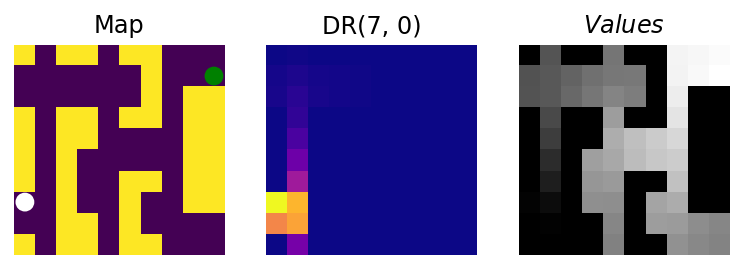

In [7]:
make_plots(agent)

In [8]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_old_goal = test_agent(agent)

Start location: [7 0], Target location: [1 9]
Starting in state: [7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 2 and arrived in state: [3 7]
Took action: 2 and arrived in state: [2 7]
Took action: 2 and arrived in state: [1 7]
Took action: 1 and arrived in state: [1 8]
Took action: 1 and arrived in state: [1 9]
Took 19 steps


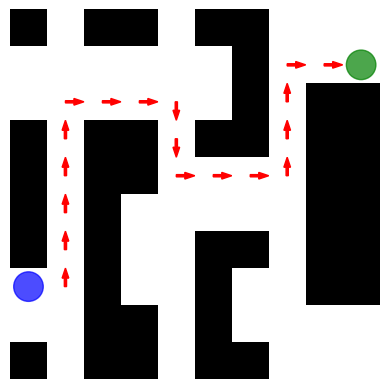

In [9]:
record_trajectory(agent, traj_old_goal)

## Get state -> state DR and T (excludes blocked squares)

In [10]:
DR = agent.DR
T = agent.T
barriers = agent.barriers

# print(DR.shape)
# print(len(barriers))
# print(barriers, "\n")
# idx = barriers[10]
# print(DR[:,idx])
# print(DR[idx,:])

In [11]:
# Drop rows and columns associated with barriers
# Convert barriers list to a NumPy array
indices = np.array(barriers)

# Create a boolean mask to identify rows and columns to keep
mask = np.ones(DR.shape[0], dtype=bool)
mask[indices] = False

# Use boolean indexing to select rows and columns to keep
DR_new = DR[mask][:, mask]
T_new = T[mask][:,mask]

In [12]:
print(f"Number of blocked squares: {len(barriers)}")
print(f"Old DR shape: {DR.shape}, New DR shape: {DR_new.shape}")
print(f"Old T shape: {T.shape}, New T shape: {T_new.shape}")

Number of blocked squares: 43
Old DR shape: (100, 100), New DR shape: (57, 57)
Old T shape: (100, 100), New T shape: (57, 57)


## New Goal

In [13]:
# Get new maze and initialize a new agent
env_new_goal = gym.make("tolman-10x10-latent-new-goal")
maze_new_goal = env_new_goal.unwrapped.maze
new_agent = LinearRL(env_name="tolman-10x10-latent-new-goal", _lambda=1.0, alpha=0.01)

In [14]:
# Find states whose transition has been changed
delta_locs = [13, 56]

In [15]:
T = T_new
T_new = new_agent.T[mask][:,mask]
DR = DR_new
r = agent.r[mask]

In [16]:
L0 = np.diag(np.exp(-r)) - T
L = np.diag(np.exp(-r)) - T_new

In [17]:
delta = L[delta_locs] - L0[delta_locs]
delta.shape

(2, 57)

In [18]:
D0 = agent.get_D_inv()[mask][:,mask]

D0_j = D0[:,delta_locs]
D0_j.shape

(57, 2)

In [19]:
I = np.eye(len(delta_locs))
I.shape

(2, 2)

In [20]:
inv = np.linalg.inv(I + np.dot(delta, D0_j))
inv.shape

(2, 2)

In [21]:
B = np.dot( np.dot(D0_j, inv), np.dot(delta, D0) )
B.shape

(57, 57)

In [65]:
D = D0 - B
D.shape

(57, 57)

In [66]:
mask_indices = np.where(mask)[0]
DR_det = np.copy(agent.DR)
DR_det[np.ix_(mask, mask)] = D

In [67]:
DR_det[1]

array([ 0.00000000e+00,  1.49672428e+00,  0.00000000e+00,  0.00000000e+00,
        6.92917421e-02,  0.00000000e+00,  0.00000000e+00,  5.41065055e-04,
        6.23371644e-04,  3.60860265e-04,  7.67229758e-01,  2.19586091e+00,
        8.07855189e-01,  4.25024881e-01,  3.06316873e-01,  1.21512763e-01,
        0.00000000e+00,  1.17053645e-03,  7.13908657e-04,  3.45687204e-04,
        5.97909577e-01,  1.10870959e+00,  6.06533619e-01,  3.71582569e-01,
        2.67237664e-01,  1.15426307e-01,  0.00000000e+00,  1.57028152e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.50431410e-01,
        0.00000000e+00,  0.00000000e+00,  7.43801323e-02,  0.00000000e+00,
        0.00000000e+00,  2.69050131e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.20218412e-01,  0.00000000e+00,  0.00000000e+00,
        4.61800296e-02,  2.21459051e-02,  1.16877464e-02,  6.56496912e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.36326560e-01,
        0.00000000e+00,  

In [68]:
D[0]

array([ 1.49672428e+00,  6.92917421e-02,  5.41065055e-04,  6.23371644e-04,
        3.60860265e-04,  7.67229758e-01,  2.19586091e+00,  8.07855189e-01,
        4.25024881e-01,  3.06316873e-01,  1.21512763e-01,  1.17053645e-03,
        7.13908657e-04,  3.45687204e-04,  5.97909577e-01,  1.10870959e+00,
        6.06533619e-01,  3.71582569e-01,  2.67237664e-01,  1.15426307e-01,
        1.57028152e-03,  3.50431410e-01,  7.43801323e-02,  2.69050131e-03,
        2.20218412e-01,  4.61800296e-02,  2.21459051e-02,  1.16877464e-02,
        6.56496912e-03,  1.36326560e-01,  8.72377516e-03,  2.58591648e-02,
        1.55572548e-02,  1.00399981e-02,  6.04274046e-03,  8.11098858e-02,
        9.52941417e-03,  1.09134436e-02,  2.28654390e-03,  3.19812097e-02,
        6.44310213e-02,  5.06385860e-03,  7.25987362e-03,  6.91929069e-04,
        1.53832501e-03,  2.77353915e-02,  4.39852298e-02,  3.70731472e-03,
        5.03849766e-04,  8.43502296e-04,  1.90808110e-04, -3.76092483e-05,
        1.32664939e-02,  

In [69]:
new_agent.DR = DR_det
new_agent.update_V()
print(new_agent.V.reshape((agent.height, agent.width)))

[[  -inf    nan   -inf   -inf    nan   -inf   -inf -43.41 -40.25 -39.51]
 [   nan    nan    nan    nan    nan    nan   -inf -41.79 -40.14 -39.4 ]
 [   nan    nan    nan    nan    nan    nan   -inf    nan   -inf   -inf]
 [  -inf    nan   -inf   -inf    nan   -inf   -inf    nan   -inf   -inf]
 [  -inf    nan   -inf   -inf    nan    nan    nan    nan   -inf   -inf]
 [  -inf    nan   -inf    nan    nan    nan    nan    nan   -inf   -inf]
 [  -inf    nan   -inf    nan -41.76   -inf   -inf -38.31   -inf   -inf]
 [   nan    nan   -inf    nan    nan   -inf    nan -37.6    -inf   -inf]
 [   nan    nan   -inf   -inf    nan   -inf    nan    nan    nan    nan]
 [  -inf    nan   -inf   -inf    nan   -inf   -inf    nan    nan   1.  ]]


/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52929/442765447.py:71: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52929/442765447.py:71: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [31]:
# differences = T != T_new

# different_rows, _ = np.where(differences)
# delta_locs = np.unique(different_rows)

# print(delta_locs)

In [18]:
# New goal location
# loc = new_agent.target_loc
# idx = agent.mapping[(loc[0], loc[1])]

In [19]:
## Old Method


# L0 = np.diag(np.exp(-agent.r)) - agent.T
# L = np.diag(np.exp(-agent.r)) - new_agent.T

# D0 = D_inv
# # D0 = agent.DR

# idx = agent.mapping[(loc[0], loc[1])]

# d = L[idx, :] - L0[idx, :]
# m0 = D0[:,idx]

# # Convert d to a row vector of size (1, m)
# d = d.reshape(1, -1)

# # Convert m0 to a column vector of size (m, 1)
# m0 = m0.reshape(-1, 1)

# # Get the amount of change to the DR
# alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
# change = np.dot(alpha,D0)

# # Apply change to DR
# D = np.copy(D0)
# D -= change

In [34]:
## New Method

L0 = np.diag(np.exp(-r)) - T
L = np.diag(np.exp(-r)) - T_new

delta = L[delta_locs] - L0[delta_locs]
print(f"delta shape: {delta.shape}")

D0 = DR
D0 = agent.get_D_inv()

D0_j = D0[:,delta_locs]
print(f"D0_j shape: {D0_j.shape}")

I = np.eye(len(delta_locs))
print(f"I shape: {I.shape}")

inv = np.linalg.inv(I + np.dot(delta, D0_j))
print(f"inv shape: {inv.shape}")

B = np.dot( np.dot(D0_j, inv), np.dot(delta, D0) )
print(f"B shape: {B.shape}")

D = D0 - B
print(f"D shape: {D.shape}")

delta shape: (2, 100)
D0_j shape: (100, 2)
I shape: (2, 2)
inv shape: (2, 2)
B shape: (100, 100)
D shape: (100, 100)


In [35]:
#### We want to recover the DR now

In [36]:
# Recover the original DR matrix with operations reflected
DR_det = np.copy(agent.DR)   # Copy the old DR
DR_det[np.ix_(mask, mask)] = D   # Replace the locations of the mask with the new DR

ValueError: shape mismatch: value array of shape (100,100) could not be broadcast to indexing result of shape (57,57)

In [44]:
# new_agent.DR = DR_det
new_agent.DR = D
new_agent.update_V()

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52748/3084750285.py:55: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_52748/3084750285.py:55: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [45]:
print(new_agent.V.reshape((agent.height, agent.width)))

[[  -inf    nan   -inf   -inf    nan   -inf   -inf -43.41 -40.25 -39.51]
 [   nan    nan    nan    nan    nan    nan   -inf -41.79 -40.14 -39.4 ]
 [   nan    nan    nan    nan    nan    nan   -inf    nan   -inf   -inf]
 [  -inf    nan   -inf   -inf    nan   -inf   -inf    nan   -inf   -inf]
 [  -inf    nan   -inf   -inf    nan    nan    nan    nan   -inf   -inf]
 [  -inf    nan   -inf    nan    nan    nan    nan    nan   -inf   -inf]
 [  -inf    nan   -inf    nan -41.76   -inf   -inf -38.31   -inf   -inf]
 [   nan    nan   -inf    nan    nan   -inf    nan -37.6    -inf   -inf]
 [   nan    nan   -inf   -inf    nan   -inf    nan    nan    nan    nan]
 [  -inf    nan   -inf   -inf    nan   -inf   -inf    nan    nan   1.  ]]


In [26]:
new_agent_traj = test_agent(new_agent)

Starting in state: [7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 0 and arrived in state: [5 7]
Took action: 0 and arrived in state: [6 7]
Took action: 0 and arrived in state: [7 7]
Took action: 0 and arrived in state: [8 7]
Took action: 1 and arrived in state: [8 8]
Took action: 1 and arrived in state: [8 9]
Took action: 0 and arrived in state: [9 9]
Took 21 steps


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


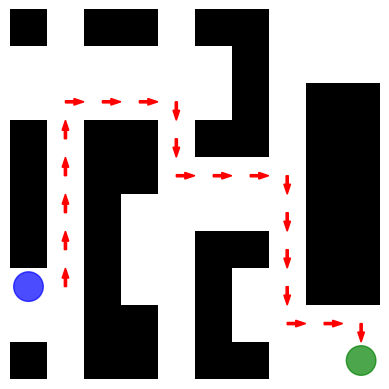

In [27]:
record_trajectory(new_agent, new_agent_traj)

In [28]:
mask.shape

(100,)

## Find Absolute Difference

In [29]:
D_inv = new_agent.get_D_inv()

In [31]:
print(F"Difference between Updated D (using D_TD) and D_inv of new environemnt: {np.max(np.abs(new_agent.DR - D_inv))}")

Difference between Updated D (using D_TD) and D_inv of new environemnt: 8.352568349014385
